In [4]:
pip install --upgrade transformers

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --upgrade pyfunctional

  Using cached PyFunctional-1.4.3-py3-none-any.whl (49 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import sys
import os
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from transformers.trainer_utils import EvaluationStrategy

In file_utils.py: default_cache_path = /raid/xd/.cache/torch/transformers


In [3]:
from functional import seq
from functional.pipeline import Sequence
from fn import _
from collections import namedtuple 

In [4]:
from utils import *
from child_utils import *
from common_utils import *

In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/vocab.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/merges.txt
In cached_path: output_path = /nas/xd/.cache/torch/transformers/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/added_tokens.json
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/special_tokens_map.json
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/tokenizer_config.json
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/config.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/

In [5]:
import random

In [6]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
proxies = {'http': '192.168.50.1:1081'} 

In [7]:
model_name = "EleutherAI/gpt-neo-1.3B"
model = GPTNeoForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
models[model_name] = model, tokenizer

In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-1.3B/resolve/main/config.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/42252c2220ae3f9f1ea86a994b63e1dcab20953ba8982117c2384587f7c01c5d.102e6e06599c480a8e55be9ba8dc6226140c958f3cd489f61627520db6817595
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-1.3B/resolve/main/pytorch_model.bin
In cached_path: output_path = /nas/xd/.cache/torch/transformers/7c5fac9d60b015cbc7c007ab8fe6d0512787fbaef81968922959898c49468d73.4c6a483fbfb5a25ac384bfcd71a1ff15245f06583a00c4ab4c44ed0f761f0b08
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/vocab.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/merges.txt
In cached_path: output_path 

In [8]:
prompt_token = 'Ġ!'; prompt_id = tokenizer._convert_token_to_id(prompt_token)
bop_str = 'Instruction: '; bop_id = tokenizer.encode(bop_str)[0]  # 'Inst'
eop_str = '. For example:'; eop_id = tokenizer.encode(eop_str)[2] # 'Ġexample'
bos_id = tokenizer._convert_token_to_id('Ġ->')
eos_id = tokenizer._convert_token_to_id('Ċ')


class CHILDDataset(Dataset):
    def __init__(self, input_strs, tokenizer):
        if tokenizer.pad_token is None: tokenizer.pad_token = '!'
        self.inputs = tokenizer.batch_encode_plus(input_strs, add_special_tokens=False, padding=True, return_tensors='pt')#长的截，短的补
        input_ids = self.inputs.input_ids
        self.labels = torch.ones_like(input_ids) * (-100)
        for bi in range(input_ids.size(0)): #bi 0-127 0-63
            bop_idx = (input_ids[bi] == bop_id).nonzero().squeeze(1) #prompt
            eop_idx = (input_ids[bi] == eop_id).nonzero().squeeze(1) #context
            if len(bop_idx) > 0:
                assert len(bop_idx) == 1 and len(eop_idx) == 1
                bop_idx, eop_idx = bop_idx.item(), eop_idx.item() #取出单元素张量的元素值并返回该值，保持原元素类型不变
                #bop: 0   eop:6
                input_ids[bi, bop_idx: eop_idx + 2] *= -1  # use prompt embedding for prompt tokens
  
            bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
#             print("bos_indices:",bos_indices)
            eos_indices = (input_ids[bi] == eos_id).nonzero()[-len(bos_indices):].squeeze(1) #每一位 eos都比bos大2
#             print("eos_indices:",eos_indices)
            for i, (bos_i, eos_i) in enumerate(zip(bos_indices.tolist(), eos_indices.tolist())):
                assert eos_i > bos_i + 1
                if i >= 2: self.labels[bi, bos_i + 1: eos_i] = input_ids[bi, bos_i + 1: eos_i] 
                    
    def re_input(self):
        return self.inputs['input_ids']
        
    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, i):
        return {'input_ids': self.inputs['input_ids'][i],  #输入
                'attention_mask': self.inputs['attention_mask'][i],
                'labels': self.labels[i]}   #结果

In [9]:
from child_utils import *
torch.set_printoptions(threshold=np.inf)

In [10]:
class WrappedEmbedding(nn.Module):
    def __init__(self,  
                wte: nn.Embedding,  #正常向量
                prompt_id: int = None,
                prompt_len: int = 10, 
                random_range: float = 0.5,
                initialize_from_vocab: bool = True):
        super(WrappedEmbedding, self).__init__()
#         self.wte = wte
#         self.prompt_id = prompt_id
#         self.prompt_len = prompt_len
        self.__dict__.update(locals()); del self.self #locals()以字典类型返回当前位置的全部局部变量
        if self.prompt_id is not None: #prompt_embedding prompt词向量
            self.prompt_embedding = nn.parameter.Parameter( #将一个不可训练的类型Tensor转换成可以训练的类型parameter
                self.initialize_embedding(random_range, initialize_from_vocab)).to(self.wte.weight.device) #在-0.5-0.5中随机取值初始化
        else:
            self.prompt_embedding = nn.Embedding(self.prompt_len, self.wte.weight.size(1)).to(self.wte.weight.device)
                                        #词典大小（总共输入多少词） 嵌入向量维度（多少维表示一个符号）
            assert initialize_from_vocab
            self.init_prompt_embedding_()  #将wte的weight值作为初始化
#             self.prompt_embedding.weight.data = self.initialize_embedding(random_range, initialize_from_vocab)     
 
    def initialize_embedding(self, random_range: float = 0.5, initialize_from_vocab: bool = True):
        if initialize_from_vocab: return self.wte.weight[:self.prompt_len].clone().detach() #返回一个新的tensor，新的tensor和原来的tensor共享数据内存，但不涉及梯度计算
        return torch.FloatTensor(self.prompt_len, self.wte.weight.size(1)).uniform_(-random_range, random_range) #产生随机数
    
    def init_prompt_embedding_(self):
        print(self.wte.weight)
        self.prompt_embedding.weight.data[:] = self.wte.weight[:self.prompt_len]
        
        
    def forward(self, input_ids):
        if self.prompt_id is not None:
            input_embeds = self.wte(input_ids)
            input_embeds[input_ids == self.prompt_id] = self.prompt_embedding.expand(input_embeds.size(0), -1, -1)
        else: # adapted from cpm-2
            prompt_mask = input_ids < 0
            prompt_ids = -input_ids * prompt_mask
            print(prompt_ids < self.prompt_len)
            print(prompt_ids)
            assert torch.all(prompt_ids < self.prompt_len)
            p_embeds = self.prompt_embedding(prompt_ids) * prompt_mask.float().unsqueeze(-1)
            input_ids = input_ids * ~prompt_mask
            w_embeds = self.wte(input_ids) * (~prompt_mask).float().unsqueeze(-1)
            input_embeds = w_embeds + p_embeds
        return input_embeds

In [11]:
# adapted from cpm-2: https://github.com/TsinghuaAI/CPM-2-Finetune/blob/master/utils.py#L133-L164
def get_params_for_prompt_optimization(module: nn.Module): #不训练模型参数，只训练prompt_embading，这个函数是取这些参数
    params = []
    for t in module.named_modules():
        if "prompt_embedding" in t[0]:
            params.append({'params': [p for p in list(t[1]._parameters.values()) if p is not None]})
    for t in module.named_parameters():
        if "prompt" not in t[0]:
            t[1].requires_grad_(False)    
    return params

def create_optimizer(model, training_args):
    from torch.nn.parallel.distributed import DistributedDataParallel as DDP
    while isinstance(model, (DDP, )): model = model.module
        
    we.init_prompt_embedding_()
    param_groups = get_params_for_prompt_optimization(model)
    optimizer = AdamW(param_groups, lr=training_args.learning_rate, 
                      betas=(training_args.adam_beta1, training_args.adam_beta2),eps=training_args.adam_epsilon)
    return optimizer

In [ ]:
wte = model.get_input_embeddings() #提取 embedding 中的 词向量部分
if hasattr(wte, 'wte'): wte = wte.wte  # already been wrapped
we = WrappedEmbedding(wte, prompt_len=15000)
model.set_input_embeddings(we) #为词向量赋值

In [16]:
def verbalize(obj):
    if type(obj) == bool: return 'Yes' if obj else 'No'
    return str(obj)

def list2str(l): return ' '.join(str(i) for i in l)
def pairs2str(pairs): return ', '.join(str(k) + ': ' + str(v) for k, v in pairs)

def make_context_str(cxt):
    if type(cxt) == list:
        return pairs2str(cxt) if type(cxt[0]) == tuple and len(cxt[0]) == 2 else list2str(cxt)
    if type(cxt) == tuple:
        return '; '.join(make_context_str(c) for c in cxt)  # 用分号分隔context的不同部分
    
def make_query_str(instruction, query):
    if instruction is None and query is None: return ''
    s = '.'
    if instruction is not None: s = s + ' ' + instruction
    if query is not None:
        if type(query) in [int, bool, str]: query = [query]
        if type(query) == dict:# and list(query.keys())[0] != "CS"):  # by nrk
            s = s + ' ' + '{' + ','.join([' replace %s with %s' % (str(k), str(v)) for k, v in query.items()]) + ' }'
        if type(query) in [list, tuple]:
            s = s + ' ' + ' '.join([list2str(i) if type(i) == list else str(i) for i in query])
    return s

def make_example_str(example, query2str):
    instruction, cxt, query, ans = example
    if type(ans) not in [Sequence, list]: ans = [ans]
    ans = [verbalize(a) for a in ans]
#     return '%s -> %s' % (''.join(l[0]) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))  # by nrk
#     return '%s -> %s' % (' '.join(l) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))  # by XD
#     return '%s -> %s' % (make_context_str(cxt) + make_query_str(instruction if with_instruction else None, query[0]), ' '.join(ans))
    return '%s -> %s' % (make_context_str(cxt) + query2str(query), ' '.join(ans))


def sample_rand_len(vocab, k): return sample(vocab, k=randint(1, k))

In [17]:
def promptize(s):
#     return prompt_token * len(s.split())
    return bop_str + s + eop_str

courses_vocab=["Sql","Math","English","Chinese","Art","Music","History","Biology","Chemistry","Physics","Geography"]
all_vocab = ["apple","pear","peach","grape","banana","pineapple","lemon","strawberry","cola","juice","coffee","milk","wine","beer","whisky","vodka","brandy"]
solid_vocab=["apple","pear","peach","grape","banana","pineapple","lemon","strawberry"]
liquid_vocab=["cola","juice","coffee","milk","wine","beer","whisky","vodka","brandy"]
names_vocab =  [i for i in string.ascii_uppercase]
depts_vocab = ["CS","Chi","Eng","Mat"]
sl = ["solid"]*len(solid_vocab)+["liquid"]*len(liquid_vocab)
sl_vocab = dict(zip(all_vocab,sl))

def make_input_str(task, nrows=4, ncols=4, full_vocab=None, ans_vocab=[True, False]):
    if full_vocab is None: full_vocab = string.ascii_uppercase + string.digits
    transform_fn, vocab_fn, sample_fn, query_fn, query2str = task
    instruction = transform_fn.__name__.replace('_', ' ')
    if vocab_fn is None: vocab_fn = lambda: full_vocab
    if query_fn is None: query_fn = lambda *_: None
        
    examples = []
    query = None
    for i in range(nrows):
        vocab = vocab_fn()
        l = sample_fn(vocab, k=ncols)
        query = query_fn(l, vocab, ncols)
        examples.append([instruction, l, query, transform_fn(l, query=query)])
    examples = balance(examples,ans_vocab)

    desc = promptize(instruction) if True else ''
    text = '\n'.join([make_example_str(e, query2str) for e in examples])
    text = desc + '\n' + text + '\n'
    return text

In [18]:
# def balance(examples, ans_vocab=[True, False]):
def balance(examples, ans_vocab):
    groups = seq(examples).group_by(_[-1]).map(_[1])  # 按ans分组
    assert groups.len() == len(ans_vocab), '%d < %d' % (groups.len(), len(ans_vocab))  # 保证每种ans都出现
    min_cnt = groups.map(lambda x: len(x)).min()
    examples = groups.map(lambda x: sample(x, min_cnt)).flatten().list() # 每组都采样最小个数后去分组
    return sample(examples, len(examples))  # 重新打乱

In [39]:
task = tasks[-8]
transform_fn, vocab_fn, sample_fn, query_fn, query2str = task
vocab = vocab_fn()
ncols = (3, 3, 2, 5)
l = sample_fn(vocab, k=ncols)
SC, CD = l
query = query_fn(l, vocab, ncols)
ss, d = query

NameError: name 'tasks' is not defined

In [16]:
import itertools  
def all_a(cxt, query):
    SC, CD = cxt  # SC paris: studeng-course relation, CD pairs: course-department function
    ss, d = query  # ss: 学生子集（可以*不止两个学生*），d: 课程
#     return seq(ss).map(lambda s: seq(SC).filter(_[0] == s).map(_[1]).intersection(CD.filter(_.[1] == d).map(_.[0])).non_empty()).all()
    return (seq(ss)
            .map(lambda s: seq(SC).filter(_[0] == s).map(_[1])  # 学生s选的所有课程
                 .intersection(
                     seq(CD).filter(_[1] == d).map(_[0])) # d系的课程
                 .non_empty())  # s选了d系的课程
            .all())  # 学生子集ss都选了d系的课程

def all_a_sample(vocab, k):
    S_vocab, C_vocab, D_vocab = vocab  # vocabs of students, courses, departments
    k_S, k_C, k_D, k_SC = k  # default values: k_S = 3, k_C = 3, k_D = 2, k_SC = 5
    S, C, D = sample(S_vocab, k_S), sample(C_vocab, k_C), sample(D_vocab, k_D)
    
    while len(set(CD := choices(D, k=k_C))) < k_D: continue  # ds里每个系的课都要出现
    CD = list(zip(C, CD))  # 得到每门课所属的系
    
    all_SC = list(itertools.product(S, C))  # or seq(S).cartesian(C).list()
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue  # ss里每个学生都要选课
    return SC, CD

def select_distinct(tuples, col): return seq(tuples).map(_[col]).distinct().list()
    
def all_a_query(cxt,vocab,k):
    SC, CD = cxt
    k_S, k_C, k_D, k_SC = k
    S, D = select_distinct(SC, 0), select_distinct(CD, 1)
    k_ss = randint(2, len(S))
    ss = sample(S, k_ss)
    d = choice(D)
    return ss, d

def all_a_query2str(query):
    ss, d = query
    query_str = 'Do %s all take %s courses?' % (', '.join(ss[:-1]) + ' and ' + ss[-1], d)
    return '. ' + query_str

In [17]:
#nrk
def all_b(cxt, query):
    SC, CD = cxt
#     ss,d = str_solve(query)  # XD: 不要在transform_fn里做解析
    ss,d = query
    return (seq(CD).filter(_[1] == d).map(_[0])
                 .difference(
                     seq(SC).filter(_[0] == ss).map(_[1]))
                 .empty())

def all_b_sample(vocab, k):
    S_vocab, C_vocab, D_vocab = vocab  
    k_S, k_C, k_D, k_SC = k  # default values: k_S = 2, k_C = 3, k_D = 2, k_SC = 5
    S, C, D = sample(S_vocab, k_S), sample(C_vocab, k_C), sample(D_vocab, k_D)
    
    while len(set(CD := choices(D, k=k_C))) < k_D: continue  
    CD = list(zip(C, CD)) 
    
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue  # ss里每个学生都要选课
    return SC, CD
   
def all_b_query(cxt,vocab,k):  # XD: 不要给qeury_fn加st参数
    SC, CD = cxt
    k_S, k_C, k_D, k_SC = k
    S, D = select_distinct(SC, 0), select_distinct(CD, 1)
#     k_ss = randint(2, len(S))  # XD: k_ss unused
    ss = choice(S)
    d = choice(D)
    return ss, d
    # XD: 不要在query_fn里转str！！这里转str，transform_fn里再解析回来，两边不是白折腾吗！

def all_b_query2str(query):
    ss, d = query
    query_str = 'Does %s take all %s courses?' % (ss, d)
    return '. ' + query_str


def Find_the_intersection_of_two_elements(cxt, query):
    SC= cxt
    s,d = query
    return (seq(SC).filter(_[0] == s).map(_[1])
                 .intersection(
                     seq(SC).filter(_[0] == d).map(_[1]))
                 .non_empty())

def intersection_query(cxt,vocab,k):
    SC= cxt
    k_S, k_C, k_SC = k #k_s = 3, k_C = 5 , k_sc = 6
    S = select_distinct(SC, 0)
    s,d = sample(S,2)
    return s, d

def intersection_query2str(query):
    s, d = query
    query_str = "Is there an intersection between %s and %s?" % (s, d)
    return '. ' + query_str

def intersection_sample(vocab, k):
    S_vocab, C_vocab = vocab  
    k_S, k_C, k_SC = k  # k_S = 3, k_C = 5, , k_SC = 6
    S, C= sample(S_vocab, k_S), sample(C_vocab, k_C)
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue 
    return SC

def complement(cxt, query):
    SC= cxt
    s,d = query
    return (seq(SC).filter(_[0] == d).map(_[1])
                 .union(
                     seq(SC).filter(_[0] == s).map(_[1]))
                 ).distinct().len()== seq(SC).filter(_[0] == d).map(_[1]).distinct().len()

def complement_query(cxt,vocab,k):
    SC= cxt
    k_S, k_C, k_SC = k #k_s = 3, k_C = 5 , k_sc = 6
    S = select_distinct(SC, 0)
    s,d = sample(S,2)
    return s, d

def complement_query2str(query):
    s, d = query
    query_str = "Is %s a subset of %s?" % (s, d)
    return '. ' + query_str

def complement_sample(vocab, k):
    S_vocab, C_vocab = vocab  
    k_S, k_C, k_SC = k  # k_S = 3, k_C = 4, k_SC = 5
    S, C= sample(S_vocab, k_S), sample(C_vocab, k_C)
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue 
    return SC

def union(cxt, query):
    SC, DC = cxt
    ss,d = query
    return (seq(ss)
            .map(lambda s: seq(SC).filter(_[0] == s).map(_[1]) 
                 .union(
                     seq(DC).filter(_[0] == d).map(_[1])) 
                 .distinct().len() == seq(DC).filter(_[0] == d).map(_[1]).distinct().len())  
            .all()) 

def union_sample(vocab, k):
    S_vocab, C_vocab, D_vocab = vocab  
    k_S, k_C, k_D, k_SC = k  # k_S = 3, k_C = 4, k_D = 2, k_SC = 6
    S, C, D = sample(S_vocab, k_S), sample(C_vocab, k_C), sample(D_vocab, k_D)
    
    while len(set(DC := choices(D, k=k_C))) < k_D: continue  
    DC = list(zip(DC,C)) 
    
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue  
    return SC, DC
   
def union_query(cxt,vocab,k): 
    SC, DC = cxt
    k_S, k_C, k_D, k_SC = k
    S, D = select_distinct(SC, 0), select_distinct(DC, 0)
    k_ss = randint(2, len(S))
    ss = sample(S, k_ss)
    d = choice(D)
    return ss, d

def union_query2str(query):
    ss, d = query
    query_str = 'Is the union of %s a subset of %s?' % (', '.join(ss[:-1]) + ' and ' + ss[-1], d)
    return '. ' + query_str

def find_same(cxt, query): #新建联系，把vocab和属性连起来形成新集合
    NA, DA = cxt
    s,d = query
    D = seq(DA).filter(_[0] == d).map(_[1])
    return (seq(NA).filter(_[0] == s).map(_[1]).select(lambda x: sl_vocab[x] == sl_vocab[D[0]]).any())
      
    
def find_sample(vocab, k): 
    name_vocab, all_vocab = vocab
    k_name, k_all, k_D, k_SA = k  # k_name = 3, k_all = 4, k_D = 2, k_SA = 6
    S = list(all_vocab.keys())
    N, A, D = sample(name_vocab, k_name), sample(S, k_all), sample(string.ascii_lowercase, k_D)
#     D = sample(d := name_vocab.pop(name_vocab.index(a) for a in N),k_D)
    A1 = sample(S, k_D)
    DA = list(zip(D,A1)) 
    
    all_NA = list(itertools.product(N, A))  
    while seq(NA := sample(all_NA, k_SA)).map(_[0]).distinct().len() < k_name: continue  
    return NA, DA
   
def find_query(cxt,vocab,k): 
    NA, DA = cxt
    k_name, k_all, k_D, k_SA = k
    S,D = select_distinct(NA, 0), select_distinct(DA, 0)
    s,d = choice(S), choice(D)
    return s, d

def find_query2str(query):
    s, d = query
    query_str = 'Is there an element in %s that belongs to the same class as %s?' % (s, d)
    return '. ' + query_str


def find_differ(cxt, query):
    NA = cxt
    ss = query
    return (seq(ss).map(lambda s: seq(NA).filter(_[0] == s).map(_[1])
                        .select(lambda x: sl_vocab[x])[0])
            .distinct().len( ) == 2)
               
def find_dif_sample(vocab, k):
    name_vocab, all_vocab = vocab
    k_name, k_all, k_SA = k  # k_name = 4, k_all = 4, k_SA= 3
    N, A = sample(name_vocab, k_name), sample(list(all_vocab.keys()), k_all) 
    NA = list(zip(N,A)) 
    return NA
   
def find_dif_query(cxt,vocab,k): 
    NA = cxt
    k_name, k_all, k_NA = k
    S = select_distinct(NA, 0)
    ss = sample(S,k_NA)
    return ss


def find_dif_query2str(query):
    ss = query
    query_str = 'Are there any elements different from other elements in %s?' % (', '.join(ss[:-1]) + ' and ' + ss[-1])
    return '. ' + query_str



In [18]:
def count(cxt, query):
    s = cxt
    q = query
    return seq(s).filter(lambda x: sl_vocab[x] == sl_vocab[q[0]]).len()
                     
def count_sample(vocab, k):
    all_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 4 ,k_query =1
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s
   
def count_query(cxt,vocab,k): 
    NA = cxt
    k_cxt,k_query = k
    N = list(vocab.keys())
    q = sample(N,k_query)
    return q

def count_query2str(query):
    q = query
    query_str = 'How many elements are similar to %s?' % (q[0])
    return '. ' + query_str

def compare(cxt, query):
    s = cxt
    q = query
    return (seq(s).filter(lambda x: sl_vocab[x] == sl_vocab[q[0]]).len() >= len(s)/2)
                     
def compare_sample(vocab, k):
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 5 ,k_query =2
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s
   
def compare_query(cxt,vocab,k): 
    NA = cxt
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k
    q = sample(s_vocab,1)+sample(l_vocab,1)
    random.shuffle(q)
    return q

def compare_query2str(query):
    ss,q = query
    query_str = 'Is the quantity similar to %s greater than that of %s?' % (q[0],q[1])
    return '. ' + query_str

In [19]:
def Ascii_size_existence(l, query): return seq(l).map(_[0] > query).any()
def Ascii_size_all(l, query): return seq(l).map(_[0] > query).all()
def Ascii_size_None(l, query): return seq(l).filter(_[0] > query).empty()
def ith_element(l, query=None): return seq(l).slice(1, 2)
def ith_group(l, query=None): return seq(l).group_by(_).select(_[1]).slice(1, 2).flatten()#.distinct()# davinci F w/ and wo dist
# def element_at_index(l, query): return seq(l).slice(query, query + 1) # davinci F
def element_at_index(l, query): return seq(l).enumerate().filter(_[0] == query).select(_[1])
def replace(l, query): return seq(l).map(lambda x: query.get(x, x))
def replace_with_the_other(l, query): # davinci F
    query = {k: (set(l) - {k}).pop() for k in l}
    return replace(l, query)
def replace_all_with(l, query): return seq(l).map(lambda x: query)  # davinci F?!
def interleave_with(l, query): return seq(l).flat_map(lambda x: [x, query])  # davinci T!!
def unique_elements(l, query=None): return seq(l).distinct() # davinci F
def how_many_unique_elements(l, query=None): return seq(l).distinct().len()  # davinci F
def how_many(l, query): return seq(l).filter(_ == query).len() # davinci F
def select_same_as(l, query): return seq(l).filter(_ == query) # simpler version of how_many. davinci F
def select_same_number_as(l, query): return seq(l).group_by(_).select(_[1]).filter(lambda x: len(x) == len(query)).flatten() # F
def includes(l, query): return seq(l).union(seq(query)).distinct().len() == seq(l).distinct().len() # davinci F
def is_included_by(l, query): return seq(l).difference(seq(query)).empty() # davinci F

In [20]:
tasks = [
    (ith_element,            None,                               sample,    None,None),
    (ith_group,              None, lambda vocab, k: seq(sample(vocab, k)).map(lambda x:[x]*randint(1, 3)).flatten().list(),None,None),
    (element_at_index,       lambda: upper_letters,              sample,    lambda l,vocab,k: randint(0, min(2,len(l)-1))),
    (replace,                None,                               sample,    lambda l,vocab,k: {choice(l): choice(vocab)}),
    (replace_with_the_other, lambda: sample(full_vocab, 2),   lambda vocab,k: sample(vocab+choices(vocab, k=k-2),k), None),
    (replace_all_with,       None,                               sample_rand_len, lambda l,vocab,k: choice(vocab)),
    (interleave_with,        None,                               sample_rand_len, lambda l,vocab,k: choice(vocab)),
    (unique_elements,        lambda: sample(upper_letters, 3),   choices,   None),
    (how_many_unique_elements,lambda: sample(upper_letters, 3),  choices,   None),
    (how_many,               lambda: sample(upper_letters, 3),   choices,   lambda l,vocab,k: choice(list(set(l)))),
    (select_same_as,         lambda: sample(upper_letters, 3),   choices,   lambda l,vocab,k: choice(list(set(l)))),
    (select_same_number_as,  None, lambda vocab, k: seq(sample(vocab, k)).map(lambda x:[x]*randint(1, 3)).flatten().list(),   
     lambda l,vocab,k: [choice(vocab)]*randint(1, 3)),
    (includes,               lambda: sample(upper_letters, 6),   sample,    lambda l,vocab,k: sample(vocab, 3)),
    (is_included_by,         lambda: sample(upper_letters, 6),   sample,    lambda l,vocab,k: sample(vocab, 5)),
    
    (Ascii_size_None,        lambda: upper_letters,              sample,    lambda l,vocab,k: "Is there no element greater than %s?" % choice(list(set(l)))),
    (Ascii_size_all,         lambda: upper_letters,              sample,    lambda l,vocab,k: "Are all elements greater than %s?" % choice(list(set(l)))),
    (Ascii_size_existence,   lambda: upper_letters,              sample,    lambda l,vocab,k: "Is there an element greater than %s?" % choice(list(set(l)))),
    
    (all_a,                  lambda: [names_vocab,courses_vocab,depts_vocab],     all_a_sample,    all_a_query, all_a_query2str),
    (all_b,                  lambda: [names_vocab,courses_vocab,depts_vocab],     all_b_sample,    all_b_query, all_b_query2str),
    (Find_the_intersection_of_two_elements,           lambda: [upper_letters,string.ascii_lowercase],     intersection_sample,    intersection_query, intersection_query2str),
    (complement,           lambda: [upper_letters,string.ascii_lowercase],     complement_sample,    complement_query, complement_query2str),
    (union,                lambda: [upper_letters,string.ascii_lowercase,depts_vocab],     union_sample,    union_query, union_query2str),
    (find_same,            lambda: [upper_letters,sl_vocab],      find_sample,    find_query, find_query2str ),
    (find_differ,          lambda: [upper_letters,sl_vocab],      find_dif_sample,  find_dif_query, find_dif_query2str ),
    (count,                lambda: sl_vocab,                                      count_sample,            count_query,count_query2str),
    (compare,              lambda: [sl_vocab,solid_vocab,liquid_vocab],          compare_sample,            compare_query,compare_query2str),
]

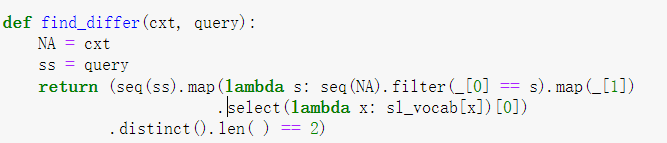

In [46]:
print(make_input_str(tasks[-3], nrows=8, ncols=(4,4,3))) 

Instruction: find differ. For example:
M: brandy, R: vodka, H: lemon, D: strawberry. Are there any elements different from other elements in D, M and H? -> Yes
R: pineapple, S: apple, G: coffee, C: whisky. Are there any elements different from other elements in G, C and R? -> Yes
S: peach, D: pineapple, J: strawberry, F: pear. Are there any elements different from other elements in D, F and S? -> No
P: apple, H: pear, T: beer, E: coffee. Are there any elements different from other elements in H, T and E? -> Yes
L: pear, M: banana, J: strawberry, D: peach. Are there any elements different from other elements in L, D and J? -> No
H: peach, A: pear, C: strawberry, B: banana. Are there any elements different from other elements in B, C and A? -> No
B: vodka, E: brandy, X: coffee, S: milk. Are there any elements different from other elements in E, X and S? -> No
B: vodka, S: juice, W: pineapple, T: banana. Are there any elements different from other elements in S, T and W? -> Yes



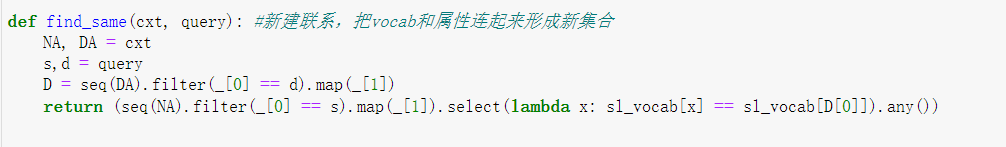

In [28]:
print(make_input_str(tasks[-4], nrows=6, ncols=(3,4,2,4)))  #找相同

Instruction: find same. For example:
E: juice, M: wine, M: banana, A: juice; b: vodka, d: whisky. Is there an element in M that belongs to the same class as b? -> Yes
L: milk, X: milk, M: beer, X: vodka; n: wine, o: apple. Is there an element in L that belongs to the same class as o? -> No



In [29]:
print(make_input_str(tasks[-1], nrows=8, ncols=(5,2))) #比较，query中给了两个元素（固体、液体），
                                                        #若前一个元素的类型数目大于后一个，就输出YES

Instruction: compare. For example:
pear lemon peach vodka beer. Is the quantity similar to c greater than that of o? -> Yes
juice cola pineapple whisky wine. Is the quantity similar to w greater than that of i? -> No
grape juice cola apple banana. Is the quantity similar to g greater than that of r? -> No
coffee peach juice whisky apple. Is the quantity similar to g greater than that of r? -> Yes



In [30]:
print(make_input_str(tasks[-2], nrows=10, ncols=(3,1), ans_vocab=[0,1,2,3]))    #数数，数cxt中与query中元素同类的个数
                                                                                  #这里修改了balance函数

Instruction: count. For example:
pear peach brandy. How many elements are similar to vodka? -> 1
apple grape banana. How many elements are similar to coffee? -> 0
beer milk cola. How many elements are similar to juice? -> 3
cola pineapple juice. How many elements are similar to juice? -> 2



In [31]:
print(make_input_str(tasks[-5], nrows=18, ncols=(3,4,2,4))) 

Instruction: union. For example:
A: w, X: a, M: a, M: w; Eng: a, CS: q, Eng: w, CS: v. Is the union of M, A and X a subset of Eng? -> Yes
R: k, M: a, E: k, R: a; Mat: a, Eng: t, Mat: v, Mat: k. Is the union of E and R a subset of Eng? -> No



In [32]:
print(make_input_str(tasks[-6], nrows=18, ncols=(3,11,5))) 

Instruction: complement. For example:
C: l, H: p, J: s, J: m, H: l. Is C a subset of H? -> Yes
S: y, J: o, S: q, R: q, J: r. Is R a subset of J? -> No
L: x, T: n, L: w, L: u, A: s. Is T a subset of L? -> No
F: h, S: z, D: h, D: r, S: u. Is F a subset of D? -> Yes
X: e, X: v, W: g, G: e, X: n. Is G a subset of X? -> Yes
B: w, E: y, B: k, P: d, E: r. Is P a subset of E? -> No
X: v, S: f, X: w, C: q, C: y. Is S a subset of C? -> No
W: p, B: r, G: x, W: r, W: c. Is B a subset of W? -> Yes



In [57]:
print(make_input_str(tasks[-7], nrows=4, ncols=(3,4,5)))

Instruction: intersection. For example:
M: e, M: j, P: d, M: d, C: t. Is there an intersection between M and P? -> Yes
G: p, H: p, J: r, G: u, H: r. Is there an intersection between J and G? -> No



In [51]:
print(make_input_str(tasks[-8], nrows=8, ncols=(3, 3, 2, 5))) 

Instruction: all b. For example:
H: English, W: English, H: Math, S: Math, W: History; English: Chi, Math: Chi, History: Eng. Does S take all Chi courses? -> No
M: History, S: Art, Z: Chemistry, M: Chemistry, M: Art; Art: Eng, History: CS, Chemistry: Eng. Does M take all CS courses? -> Yes



In [1009]:
courses = ['Math', 'Chem', "Algebra"]
depts = ['CS', 'Phy']

In [1028]:
list(zip(random.choices(depts, k=len(courses)), courses))

[('Phy', 'Math'), ('CS', 'Chem'), ('Phy', 'Algebra')]

In [32]:
tokenizer.tokenize(' intersection')

['Ġintersection']

In [927]:
print(make_input_str(tasks[-6], nrows=8, ncols=6)) #AB两人是否全部选了CS课程

Instruction: all. For example:
B:Math A:Analytcal_Chemistry B:Physics A:Linear_Algebra CS:Math CS:Analytcal_Chemistry. Do A,B all choose CS courses? -> Yes
A:Art CS:Analytcal_Chemistry B:Biology B:English CS:Biology A:Analytcal_Chemistry. Do A,B all choose CS courses? -> Yes
A:General_Chemistry CS:General_Chemistry CS:Environmental_Monitoring A:Environmental_Monitoring B:Sql B:C_language. Do A,B all choose CS courses? -> No
B:Math B:Sql A:History CS:Math A:Physics CS:History. Do A,B all choose CS courses? -> Yes
A:Physics B:History A:Biology CS:Physics CS:History B:General_Chemistry. Do A,B all choose CS courses? -> Yes
A:Analytcal_Chemistry B:Chinese CS:General_Chemistry CS:Sql B:Sql A:General_Chemistry. Do A,B all choose CS courses? -> Yes
A:Sql CS:Music B:Environmental_Monitoring CS:Sql A:Music B:English. Do A,B all choose CS courses? -> No
B:Geography A:Math B:Physics CS:Math A:General_Chemistry CS:Geography. Do A,B all choose CS courses? -> Yes



In [169]:
print(make_input_str(tasks[-2], nrows=8, ncols=4))

Instruction: all. For example:
CS:Analytcal_Chemistry A:Chinese B:Linear_Algebra A:Math. Do A,B all choose CS courses? -> Yes
CS:Environmental_Monitoring CS:C_language B:C_language A:Environmental_Monitoring. Do A,B all choose CS courses? -> No
A:Linear_Algebra CS:General_Chemistry B:Physics B:Art. Do A,B all choose CS courses? -> Yes
A:Geography CS:Biology B:Environmental_Monitoring B:C_language. Do A,B all choose CS courses? -> Yes
B:Art CS:Art CS:Music A:Operating_Systems. Do A,B all choose CS courses? -> No
CS:Physics B:General_Chemistry A:Chinese CS:Chinese. Do A,B all choose CS courses? -> No
CS:Linear_Algebra CS:Music B:Music B:Geography. Do A,B all choose CS courses? -> No
A:Linear_Algebra B:General_Chemistry CS:C_language A:Math. Do A,B all choose CS courses? -> Yes



In [37]:
# n_total, n_valid = 1800, 360  #全部数目，测试数目
n_total, n_valid = 180, 60
n_train = n_total - n_valid
input_strs = [make_input_str(tasks[-7], nrows=25, ncols=(3,4,5)) for __ in range(n_total)]
# input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)
# print(input_strs)

Instruction: Find the intersection of two elements. For example:
M: a, I: k, I: c, M: k, D: m. Is there an intersection between I and D? -> No
T: i, P: t, W: i, T: y, P: y. Is there an intersection between P and W? -> No
E: r, E: o, D: r, D: v, X: q. Is there an intersection between D and X? -> No
E: v, R: u, X: u, E: k, X: d. Is there an intersection between X and E? -> No
W: j, A: q, W: q, L: j, W: e. Is there an intersection between A and W? -> Yes
R: j, R: e, W: c, P: j, W: e. Is there an intersection between R and P? -> Yes
R: b, D: w, C: c, C: b, D: c. Is there an intersection between D and C? -> Yes
H: w, D: k, P: k, H: k, D: q. Is there an intersection between H and P? -> Yes
C: p, M: y, M: p, M: i, W: p. Is there an intersection between W and M? -> Yes
W: j, C: n, B: o, W: o, W: n. Is there an intersection between B and C? -> No
M: l, M: i, F: l, X: g, M: q. Is there an intersection between X and M? -> No
J: l, I: l, I: u, J: u, A: l. Is there an intersection between I and J? 

In [22]:
sum(s.count('Yes') for s in input_strs)
sum(s.count('No') for s in input_strs)

17096

17096

In [25]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [24]:
print(n_total)

1800


In [26]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [27]:
training_args = TrainingArguments(output_dir="./models/model_name",  #模型预测和检查点的输出目录
    overwrite_output_dir=True, do_train=True, do_eval=True, prediction_loss_only=False,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,  #每个GPU / TPU内核/ CPU的批处理大小
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,    #weight_decay要应用的权重衰减,adam_epsilon AdamW优化器的ε超参数
    lr_scheduler_type='constant', learning_rate=1e-3, num_train_epochs=2,  #learning_rate:Adam初始学习率
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,  #save_steps保存两个检查点之前的更新步骤数
    no_cuda=False, report_to='none',  # to avoid report to wandb
)

In [28]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/nas/xd/projects/transformers/src/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
trainer.train()

***** Running training *****
  Num examples = 1440
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 180


AssertionError: 

In [140]:
trainer.train()


***** Running training *****
  Num examples = 128
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Epoch,Training Loss,Validation Loss
1,0.786300,0.735548
2,0.698500,0.675856
3,0.648200,0.660071
4,0.617100,0.639453


***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=32, training_loss=0.6875235140323639, metrics={'train_runtime': 2022.7462, 'train_samples_per_second': 0.253, 'train_steps_per_second': 0.016, 'total_flos': 2674345778872320.0, 'train_loss': 0.6875235140323639, 'epoch': 4.0})

In [148]:
trainer.train()

***** Running training *****
  Num examples = 128
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 80


Epoch,Training Loss,Validation Loss
1,0.786300,0.735548
2,0.698500,0.675856
3,0.648200,0.660071
4,0.617100,0.639453
5,0.606500,0.638131
6,0.591500,0.619811
7,0.595500,0.613889
8,0.580400,0.620138
9,0.566700,0.600722
10,0.558500,0.606176


***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=80, training_loss=0.6249251246452332, metrics={'train_runtime': 4331.7206, 'train_samples_per_second': 0.295, 'train_steps_per_second': 0.018, 'total_flos': 6685864447180800.0, 'train_loss': 0.6249251246452332, 'epoch': 10.0})

In [128]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 64
  Batch size = 16


{'eval_loss': 0.8791098594665527,
 'eval_runtime': 102.8425,
 'eval_samples_per_second': 0.622,
 'eval_steps_per_second': 0.039,
 'epoch': 4.0}

In [156]:
trainer.train()

***** Running training *****
  Num examples = 128
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Epoch,Training Loss,Validation Loss
1,0.786300,0.735548
2,0.698500,0.675856


***** Running Evaluation *****
  Num examples = 64
  Batch size = 16
***** Running Evaluation *****
  Num examples = 64
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=16, training_loss=0.7423961162567139, metrics={'train_runtime': 980.2575, 'train_samples_per_second': 0.261, 'train_steps_per_second': 0.016, 'total_flos': 1337172889436160.0, 'train_loss': 0.7423961162567139, 'epoch': 2.0})

In [81]:
trainer.place_model_on_device

True

In [82]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [83]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [85]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])

index,value
0,A
1,B
2,C
3,B


['C']

['b']

[2]

['C', 'A', 'B', 'B']

['B', 'B', 'C', 'A']

index,value
0,A
1,A
2,C
3,B


False

['A', 'B', 'B', 'C', 'C']

[1, 1, 2, 1, 2, 3]

['B']

['B']